In [1]:
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, ConnectionPatch, FancyArrowPatch
import numpy as np
import time

In [2]:
Graph = nx.nx_agraph.read_dot('./Dataset/noname.dot/noname.dot') #Small Directed Network 

edge_list = []
for e in Graph.edges():
    u,v = e
    edge_list.append((int(u),int(v)))

G = nx.DiGraph()
G.add_edges_from(edge_list)

node_list = [] 
for node in G.nodes():
    node_list.append(node)

print(f'the number of edges is {len(edge_list)}\n the number of nodes is {len(node_list)}')


the number of edges is 27
 the number of nodes is 24


In [3]:
adjacency_list = dict()
for edge in edge_list:
    source, target = edge
    if source not in adjacency_list:
        adjacency_list[source] = []
    adjacency_list[source].append(target)
print(adjacency_list)

{5: [13], 13: [3], 3: [15], 6: [14], 14: [21], 15: [7], 7: [18], 11: [8, 9], 9: [1], 16: [10, 2], 4: [9], 2: [17], 18: [3], 17: [3, 16], 19: [20], 20: [6, 12], 12: [8], 21: [11, 19], 22: [3], 1: [23], 23: [12], 24: [16]}


In [4]:
in_degree_list = {int(node): G.in_degree(node) for node in G.nodes()}
print(f'the In degree list is\n {in_degree_list}\n')


out_degree_list = {int(node): G.out_degree(node) for node in G.nodes()}
print(f'the Out degree list is:\n {out_degree_list}')

the In degree list is
 {5: 0, 13: 1, 3: 4, 15: 1, 6: 1, 14: 1, 21: 1, 7: 1, 18: 1, 11: 1, 8: 2, 9: 2, 1: 1, 16: 2, 10: 1, 2: 1, 4: 0, 17: 1, 19: 1, 20: 1, 12: 2, 22: 0, 23: 1, 24: 0}

the Out degree list is:
 {5: 1, 13: 1, 3: 1, 15: 1, 6: 1, 14: 1, 21: 2, 7: 1, 18: 1, 11: 2, 8: 0, 9: 1, 1: 1, 16: 2, 10: 0, 2: 1, 4: 1, 17: 2, 19: 1, 20: 2, 12: 1, 22: 1, 23: 1, 24: 1}


In [5]:
#a dictionary where keys are in-degrees/out-degree  and values are lists of nodes with that in-degree
inverted_in_degree_list = {}
for node, degree in in_degree_list.items():
    inverted_in_degree_list.setdefault(degree, []).append(node)

print(f' a dictionary of in-degree of nodes:\n {inverted_in_degree_list}\n')


inverted_out_degree_list = {}
for node, degree in out_degree_list.items():
    inverted_out_degree_list.setdefault(degree, []).append(node)

print(f' a dictionary of out-degree of nodes: \n {inverted_out_degree_list}')

 a dictionary of in-degree of nodes:
 {0: [5, 4, 22, 24], 1: [13, 15, 6, 14, 21, 7, 18, 11, 1, 10, 2, 17, 19, 20, 23], 4: [3], 2: [8, 9, 16, 12]}

 a dictionary of out-degree of nodes: 
 {1: [5, 13, 3, 15, 6, 14, 7, 18, 9, 1, 2, 4, 19, 12, 22, 23, 24], 2: [21, 11, 16, 17, 20], 0: [8, 10]}


In [6]:
def feedback_arc_set(G):
    G_copy = G.copy()
    fas = set()

    while True:
        try:
            cycle = nx.find_cycle(G_copy, orientation='original') # Find a cycle
        except nx.NetworkXNoCycle:   # If no more cycles
            break

        # how many cycles
        cycle_edge_counts = {}
        for edge in cycle:
            u, v, _ = edge  
            G_copy.remove_edge(u, v)
            cycle_count = sum(1 for _ in nx.simple_cycles(G_copy))
            cycle_edge_counts[(u, v)] = cycle_count
            G_copy.add_edge(u, v)

        edge_to_remove = max(cycle_edge_counts, key=cycle_edge_counts.get)
        G_copy.remove_edge(*edge_to_remove)
        fas.add(edge_to_remove)

    return fas

def rev_feedback_arc_set(G, fas):
    rev_fas= set()
    for edge in fas:
        u,v = edge
        rev_fas.add((v,u))
    return rev_fas

def original_graph_without_cycles(G, fas):
    G1 = G.copy()
    for edge in feedback_arc_set(G):
        u,v = edge
        G1.remove_edge(u,v)
    return G1

def dag_graph(G, fas):
    G_a = G.copy()
    G1 =original_graph_without_cycles(G_a, fas)
    for edge in rev_feedback_arc_set(G, fas):
        u,v = edge
        G1.add_edge(u,v)
    return G1

In [7]:
fas = feedback_arc_set(G)
print("Feedback arc set:", fas)

rev_fas = rev_feedback_arc_set(G, fas)
print("Reverse feedback arc set:", rev_fas)

G2 = dag_graph(G, fas)

original_edges = list()
for edge in original_graph_without_cycles(G, fas).edges():
    u,v =edge
    original_edges.append((u,v))
reversed_edges = list(rev_feedback_arc_set(G, fas))


Feedback arc set: {(16, 2), (6, 14), (3, 15)}
Reverse feedback arc set: {(14, 6), (2, 16), (15, 3)}


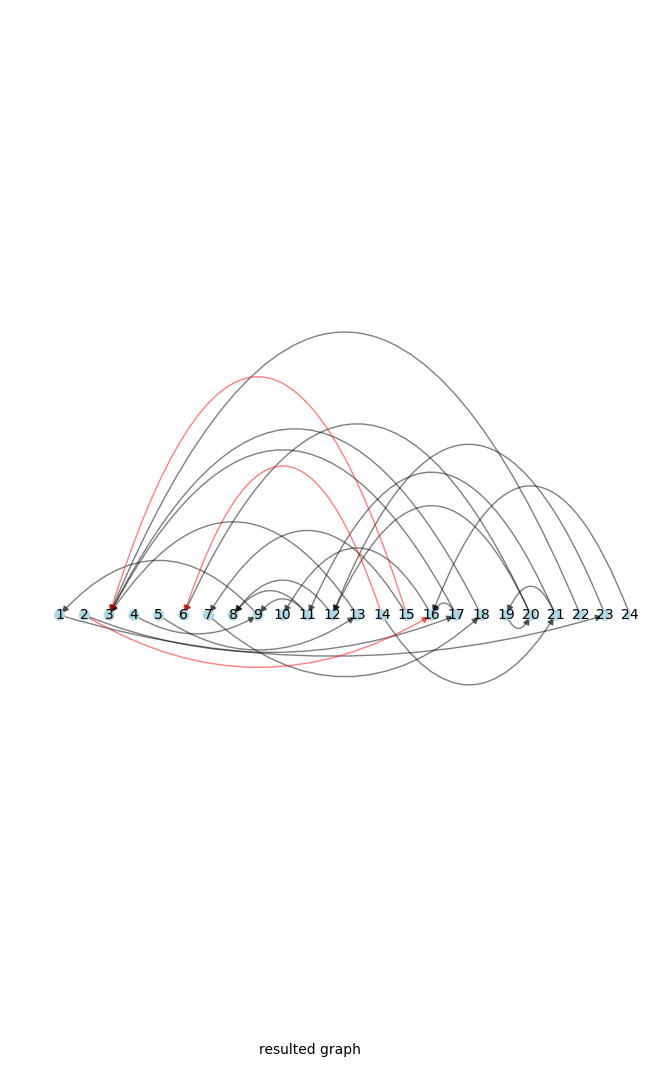

In [8]:
def draw_curved_arrow(ax, A, B, color='black', rad=0.2):
    # specify a "radius" for the arc
    control_point = [(A[0]+B[0])/2, (A[1]+B[1])/2 + rad]
    arrow = FancyArrowPatch(A, B, connectionstyle=f"arc3,rad={rad}",
                            color=color, arrowstyle='-|>',
                            mutation_scale=10.0,
                            lw=1, alpha=0.5)
    ax.add_patch(arrow)



pos = {node: (node, 0) for node in G.nodes()}  # Positions for all nodes in a line

fig, ax = plt.subplots(figsize=(8, 12))

for node in G.nodes():
    circle = Circle(pos[node], 0.2, fill=True, color='lightblue', zorder=2)
    ax.add_patch(circle)
    plt.text(pos[node][0], pos[node][1], str(node), fontsize=10, ha='center', va='center', zorder=3)

for edge in original_edges:
    draw_curved_arrow(ax, pos[edge[0]], pos[edge[1]], rad=0.1 + 0.05 * edge[0])

    
for edge in reversed_edges:
    draw_curved_arrow(ax, pos[edge[0]], pos[edge[1]], rad=0.1 + 0.1 * edge[0], color='red')

plt.axis('equal')
plt.axis('off')
plt.xlim(-1, len(G.nodes()))  # Set limits to include all nodes and edges
plt.figtext(0.5, 0.01, "resulted graph", ha="center", fontsize=10) 
#             bbox={"facecolor":"orange", "alpha":0.5, "pad":5})
plt.show()


Feedback arc set based on order: {(21, 19), (16, 2), (18, 3)}
Reverse feedback arc set: {(3, 18), (2, 16), (19, 21)}


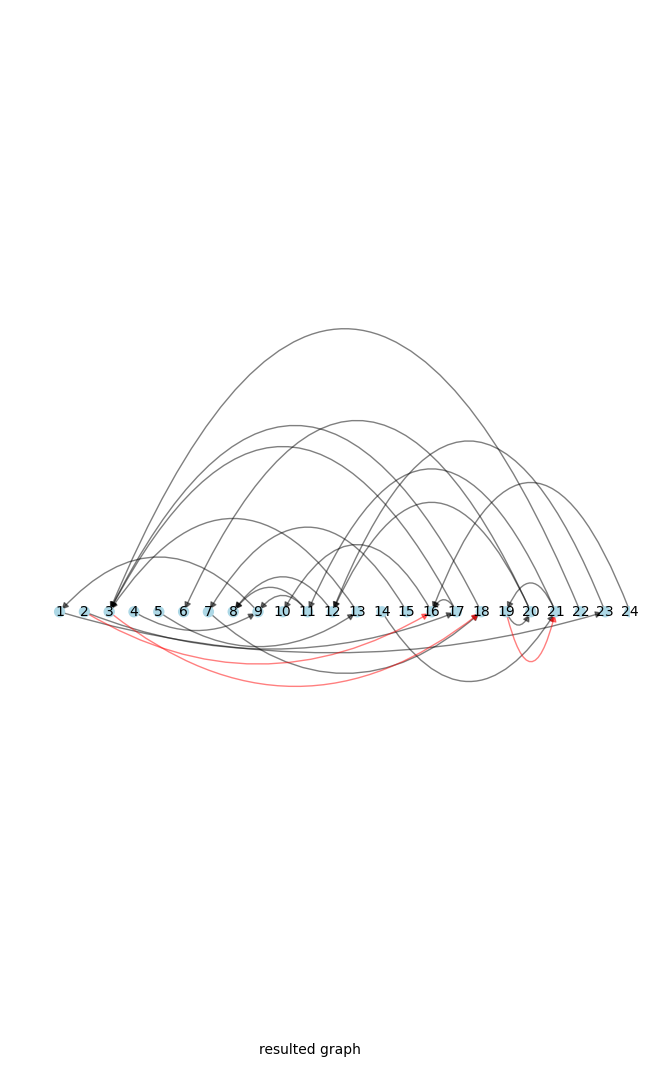

In [9]:
def feedback_arc_set_ordered(G, node_order):
    backward_edges = [(u, v) for u, v in G.edges() if node_order.index(u) > node_order.index(v)]
    
    fas = set()
    G_copy = G.copy()

    # Only consider cycles include a backward edge
    cycles_with_backward_edges = [cycle for cycle in nx.simple_cycles(G_copy) if any(edge in backward_edges for edge in zip(cycle, cycle[1:] + cycle[:1]))]

    for cycle in cycles_with_backward_edges:
        for edge in zip(cycle, cycle[1:] + cycle[:1]):
            if edge in backward_edges:
                fas.add(edge)
                G_copy.remove_edge(*edge)  
                break 

    assert nx.is_directed_acyclic_graph(G_copy), "The resulting graph is not acyclic."
    
    return fas


node_order = [i for i in range(1,len(node_list)+1)]  # This should be your predefined order of nodes
fas = feedback_arc_set_ordered(G, node_order)
print("Feedback arc set based on order:", fas)

rev_fas = rev_feedback_arc_set(G, fas)
print("Reverse feedback arc set:", rev_fas)

G2 = dag_graph(G, fas)


original_edges = list()
for edge in original_graph_without_cycles(G, fas).edges():
    u,v =edge
    original_edges.append((u,v))
reversed_edges = list(rev_feedback_arc_set(G, fas))

fig, ax = plt.subplots(figsize=(8, 12))

for node in G.nodes():
    circle = Circle(pos[node], 0.2, fill=True, color='lightblue', zorder=2)
    ax.add_patch(circle)
    plt.text(pos[node][0], pos[node][1], str(node), fontsize=10, ha='center', va='center', zorder=3)
    
for edge in original_edges:
    draw_curved_arrow(ax, pos[edge[0]], pos[edge[1]], rad=0.1 + 0.05 * edge[0])

    
for edge in reversed_edges:
    draw_curved_arrow(ax, pos[edge[0]], pos[edge[1]], rad=0.1 + 0.1 * edge[0], color='red')

plt.axis('equal')
plt.axis('off')
plt.xlim(-1, len(G.nodes()))  
plt.figtext(0.5, 0.01, "resulted graph", ha="center", fontsize=10) 
plt.show()


In [10]:
def N_outgoing(v, G):
    return {(v, u) for u in G.successors(v)}

def N_incoming(v, G):
    return {(u, v) for u in G.predecessors(v)}

def N(v, G):
    return N_outgoing(v, G).union(N_incoming(v, G))

node = 1  #Example
outgoing_edges = N_outgoing(node, G)
incoming_edges = N_incoming(node, G)
all_connected_edges = N(node, G)

print(f"Outgoing edges from node {node}: {outgoing_edges}")
print(f"Incoming edges to node {node}: {incoming_edges}")
print(f"All edges connected to node {node}: {all_connected_edges}")


Outgoing edges from node 1: {(1, 23)}
Incoming edges to node 1: {(9, 1)}
All edges connected to node 1: {(1, 23), (9, 1)}


In [11]:
def heuristic_with_guarantees(G):
    A_prime = set()
    
    G_copy = G.copy()

    while len(G_copy.nodes) > 0:
        sinks = [v for v in G_copy.nodes if G_copy.in_degree(v) > 0 and G_copy.out_degree(v) == 0]
        for v in sinks:
            A_prime.update(N_incoming(v, G_copy))
            G_copy.remove_node(v)

        isolated_nodes = list(nx.isolates(G_copy))
        G_copy.remove_nodes_from(isolated_nodes)
        
        sources = [v for v in G_copy.nodes if G_copy.out_degree(v) > 0 and G_copy.in_degree(v) == 0]
        for v in sources:
            A_prime.update(N_outgoing(v, G_copy))
            G_copy.remove_node(v)

        # If graph is non-empty, select a node with max |N_outgoing| - |N_incoming|
        if len(G_copy.nodes) > 0:
            v = max(G_copy.nodes, key=lambda v: G_copy.out_degree(v) - G_copy.in_degree(v))
            A_prime.update(N_outgoing(v, G_copy))
            G_copy.remove_node(v)

    return A_prime

In [12]:
A_prime = heuristic_with_guarantees(G)
A_minus_A_prime = set(G.edges()) - A_prime
print("Edges in the acyclic subgraph:", A_prime)
print("A_minus_A_prime:", A_minus_A_prime)

Edges in the acyclic subgraph: {(4, 9), (21, 19), (19, 20), (24, 16), (17, 3), (15, 7), (5, 13), (1, 23), (20, 6), (20, 12), (22, 3), (21, 11), (12, 8), (11, 8), (7, 18), (16, 10), (17, 16), (6, 14), (11, 9), (13, 3), (16, 2), (23, 12), (9, 1), (3, 15)}
A_minus_A_prime: {(2, 17), (14, 21), (18, 3)}


# Height Optimization

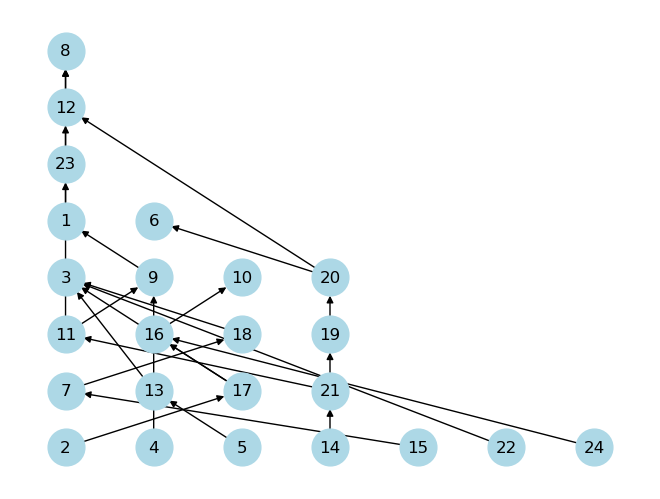

In [13]:
def original_graph_without_cycles(G, fas):
    G1 = G.copy()
    for edge in feedback_arc_set(G):
        u,v = edge
        G1.remove_edge(u,v)
    return G1

def layer_assignment(G):
    layers = {}
    i = 0
    G_copy = G.copy()
    
    while True:
        S = {v for v, d in G_copy.in_degree() if d == 0}
        if not S:
            remaining_nodes = set(G_copy.nodes())
            if not remaining_nodes:
                break  
            # Find node with the highest in-degree
            new_source = max(remaining_nodes, key=lambda x: G_copy.in_degree(x))
            S = {new_source}
        
        layers[i] = S
        G_copy.remove_nodes_from(S)
        i += 1

    return layers

def draw_layered_graph(G, layers):
    pos = {}
    for layer, nodes in layers.items():
        for i, node in enumerate(sorted(nodes)):
            pos[node] = (i, -layer)

    nx.draw(G, pos, with_labels=True, node_size=700, node_color='lightblue', arrows=True)
    plt.gca().invert_yaxis()


node_order = [i for i in range(1,len(node_list)+1)] 
fas = feedback_arc_set_ordered(G, node_order)

G_dag = original_graph_without_cycles(G, fas)

layers = layer_assignment(G_dag)

draw_layered_graph(G_dag, layers)
# reversed_edges = list(rev_feedback_arc_set(G, fas))

plt.show()


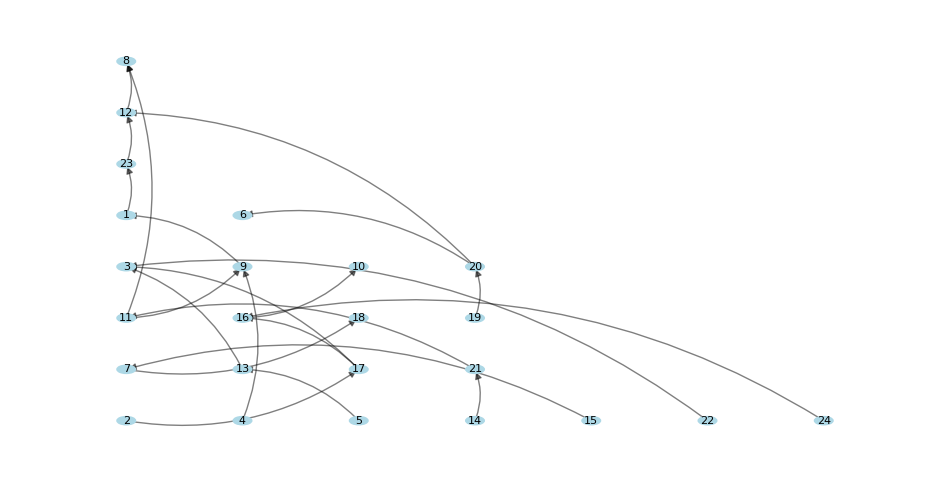

In [14]:
# import matplotlib.pyplot as plt
# from matplotlib.patches import FancyArrowPatch

# # This is the same function you provided, unchanged.
# def draw_curved_arrow(ax, A, B, color='black', rad=0.2):
#     control_point = [(A[0]+B[0])/2, (A[1]+B[1])/2 + rad]
#     arrow = FancyArrowPatch(A, B, connectionstyle=f"arc3,rad={rad}",
#                             color=color, arrowstyle='-|>',
#                             mutation_scale=10.0,
#                             lw=1, alpha=0.5)
#     ax.add_patch(arrow)

def draw_layered_graph_n(G, layers, fas, ax):
    pos = {}
    for layer, nodes in layers.items():
        for i, node in enumerate(sorted(nodes)):
            pos[node] = (i, layer)

    for node, (x, y) in pos.items():
        circle = plt.Circle((x, y), 0.08, color='lightblue', zorder=2)
        ax.add_patch(circle)
        ax.text(x, y, str(node), fontsize=8, ha='center', va='center', zorder=3)

    for edge in G.edges():
        if edge not in fas:
            draw_curved_arrow(ax, pos[edge[0]], pos[edge[1]], color='black')

#     for edge in fas:
#         draw_curved_arrow(ax, pos[edge[1]], pos[edge[0]], color='red', rad=-0.2)

    ax.set_xlim(-1, max(len(layer) for layer in layers.values()))
    ax.set_ylim(-1, len(layers))
    ax.axis('off')

node_order = [i for i in range(1,len(node_list)+1)] 
fas = feedback_arc_set_ordered(G, node_order)

G_dag = original_graph_without_cycles(G, fas)
layers = layer_assignment(G_dag)

fig, ax = plt.subplots(figsize=(12, 6))

draw_layered_graph_n(G_dag, layers, fas, ax)

plt.show()


# Crossing Minimization